In [26]:
import sys
import os
import cv2
import numpy as np
import tensorflow
import keras
import keras, keras.layers as L
sys.path.append("..")

In [27]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")


x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (28, 28)) for image in x_test]
x_train = [cv2.resize(image, (28, 28)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)

y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])
img_shape=(28,28,3)

In [28]:
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [29]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    NFILTERS=16
    N1=256

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.normalization.BatchNormalization(axis=1))
    
    #Convolutions
    encoder.add(L.Conv2D(filters=NFILTERS*2,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.MaxPooling2D())

    
    encoder.add(L.Flatten()) 
    
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())    
    
    encoder.add(L.Dense(code_size))
   
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.normalization.BatchNormalization())
    
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())   
    
    
    decoder.add(L.Dense(np.prod(img_shape)//4))
    decoder.add(L.advanced_activations.LeakyReLU()) 
    decoder.add(L.normalization.BatchNormalization()) 
    decoder.add(L.Reshape((H//2,W//2,C)))   
    decoder.add(L.UpSampling2D())

    decoder.add(L.Deconv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=NFILTERS*2,kernel_size=3,padding="same")) 
    
    encoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=3,kernel_size=3,padding="same"))

    
    return encoder,decoder

In [30]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [31]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    batch=X.shape[0]
    height=X.shape[1]
    width=X.shape[2]
    noise=np.clip(np.random.normal(loc=0,scale=sigma,size=(batch,height,width,3)),a_max=1,a_min=0)
        
    return X + noise


for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    x_train_noise = apply_gaussian_noise(x_train)
    x_test_noise = apply_gaussian_noise(x_test)
    
    autoencoder.fit(x=x_train_noise,y=x_train,epochs=1,
                    validation_data=[x_test_noise,x_test])

Epoch 0/50, Generating corrupted samples...
Train on 4575 samples, validate on 2520 samples
Epoch 1/1
 256/4575 [>.............................] - ETA: 1:31 - loss: 14208.1207

KeyboardInterrupt: 

In [32]:
images = x_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [33]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/Users/bedabratachoudhury/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [34]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [35]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

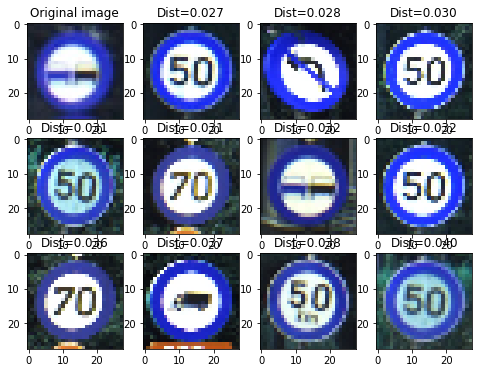

In [36]:
import matplotlib.pyplot as plt
show_similar(x_test[6])
plt.show()